<a href="https://colab.research.google.com/github/wakristensen/machine-learning-workshop/blob/main/02_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02 Kundefeatures

<div class="badges">
  <a>⏱️ 40 min</a>
  <a>👩‍💻 Hands-on</a>
  <a>📦 UK Online Retail 2010–2011</a>
</div>

---

Nå har vi forstått og renset dataene.  

Vi har nå et transaksjonsdatasett som er renset for:
- Manglende verdier (CustomerID og Description)  
- Duplikater  
- Nullpriser (UnitPrice = 0)  
- Tjeneste-relaterte beskrivelser (eks. "Next Day Carriage")  
- Feil / Dårlige / anomalie *StockCodes* (eks. "POST", "BANK CHARGES")  
---

Datasettet består nå av rene transaksjoner som representerer faktiske kjøp.

I denne modulen skal vi:
- Bygge kundevariabler (features)
- Skalere dimensjoner
- Redusere antall dimensjoner (PCA)
- Kjøre K-means clustering
- Tolke segmentene

## Import av pakker

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
# Ferdig kode for å kjøre raskt gjennom rensestegene i forrige notebook
file_id = "1Ku-y5BE5CdGQwzEMQ491cfIYWILS6T8U"
url = f"https://drive.google.com/uc?id={file_id}"

# Dette matcher stegene vi gjorde tidligere, slik at radantallet skal bli likt.
def clean_transactions(df: pd.DataFrame):
    out = df.copy()
    # 3.1 Fjerne rader uten CustomerID eller Description
    out = out.dropna(subset=["CustomerID", "Description"])
    # 3.2 Fjern helt identiske duplikater
    out = out.drop_duplicates()
    # 3.3 Merk kansellerte transaksjoner (beholdes, men markeres)
    out["InvoiceNo"] = out["InvoiceNo"].astype(str)
    out["Transaction_Status"] = np.where(
        out["InvoiceNo"].str.startswith("C"), "Cancelled", "Completed"
    )
    # 3.6 Fjern rader med UnitPrice <= 0
    out = out[out["UnitPrice"] > 0]
    # 3.4 Fjern anomale StockCodes (0 eller 1 siffer, f.eks. POST, BANK CHARGES, ...)
    unique_codes = out["StockCode"].astype(str).unique()
    anomalous_codes = {
        code for code in unique_codes if sum(ch.isdigit() for ch in code) in (0, 1)
    }
    if anomalous_codes:
        out = out[~out["StockCode"].astype(str).isin(anomalous_codes)]

    # 3.5 Fjern tjeneste-/metadata-beskrivelser og standardiser casing
    service_related = {"NEXT DAY CARRIAGE", "HIGH RESOLUTION IMAGE"}
    out = out[~out["Description"].astype(str).str.upper().isin(service_related)]
    out["Description"] = out["Description"].astype(str).str.upper().str.strip()

    # Reset index til slutt
    out = out.reset_index(drop=True)
    return out, anomalous_codes

# --- Kjør rens ---
df = pd.read_csv(url, encoding="latin1")
df, anomalous_codes = clean_transactions(df)

# --- Rapportering ---
EXPECTED_ROWS = 399573  # mål: matche radantallet fra del 1
print(f"Rader etter rensing: {len(df)}")
print(f"Forventet antall rader fra del 1: {EXPECTED_ROWS}")
if len(df) == EXPECTED_ROWS:
    print("✅ Match med del 1")
else:
    print("⚠️ Avvik fra del 1. Sjekk at URL og kildedata er identiske, og at cellene i del 1 ble kjørt i samme rekkefølge.")

# Se på de første radene
df.head()


Rader etter rensing: 399573
Forventet antall rader fra del 1: 399573
✅ Match med del 1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed


## Fra transaksjoner til kundeprofiler

Datasettet vårt er transaksjonsbasert (hver rad = en vare i en ordre).  
For å kunne klustre kunder, trenger vi å lage **kundeprofiler**:

- **RFM-variabler:** Recency, Frequency, Monetary  
- **Produktdiversitet:** Hvor mange ulike produkter har kunden kjøpt?  
- **Atferdsvariabler:** Når på døgnet eller hvilke dager handler kunden?  
- **Geografi:** Hovedland for kunden (UK eller ikke)  
- **Kanselleringer:** Hvor ofte kansellerer kunden?  

Disse nye variablene (features) gir oss et kunde-sentrisk datasett som er egnet for clustering.


Se for deg at du er markedsdirektør.  
Hvilke typer kundesegmenter ville du vært interessert i å identifisere?  

Eksempler:  
- Høyt verdifulle kunder (stor omsetning, lojale)  
- "Sovende" kunder (lenge siden sist kjøp)  
- Små, hyppige kjøpere  
- Kunder med høy kanselleringsrate  

Hvilke segmenter dere tror vil dukke opp når vi bygger features?


## 2.1 RFM

- **Recency**, dager siden siste kjøp
- **Frequency**, antall transaksjoner
- **Monetary**, total spend og snitt pr transaksjon

Vi bygger alt i en ny DataFrame som vi kaller `customer_data`.


In [ ]:
# TODO: Bygg Recency
# Finner siste kjøpsdato per kunde
# Finner mest nylige dato i hele datasettet
# Regner ut Days_Since_Last_Purchase

most_recent = pd.to_datetime(df["InvoiceDate"]).max()

customer_data = (
    df.groupby("CustomerID")["InvoiceDate"]
      .max()
      .reset_index()
      .rename(columns={"InvoiceDate":"LastPurchaseDate"})
)

customer_data["LastPurchaseDate"] = pd.to_datetime(customer_data["LastPurchaseDate"])
customer_data["Days_Since_Last_Purchase"] = (most_recent - customer_data["LastPurchaseDate"]).dt.days
customer_data = customer_data.drop(columns=["LastPurchaseDate"])

customer_data

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,129
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4357,18280.0,277
4358,18281.0,180
4359,18282.0,121
4360,18283.0,95


In [ ]:
# Frequency
total_tx = (
    df.groupby("CustomerID")["InvoiceNo"]
      .nunique()
      .reset_index()
      .rename(columns={"InvoiceNo":"Total_Transactions"})
)

# Monetary
df["Total_Spend"] = df["UnitPrice"] * df["Quantity"]
total_spend = (
    df.groupby("CustomerID")["Total_Spend"]
      .sum()
      .reset_index()
)

# Merge
customer_data = customer_data.merge(total_tx, on="CustomerID", how="left")
customer_data = customer_data.merge(total_spend, on="CustomerID", how="left")

# Average transaction value
customer_data["Average_Transaction_Value"] = (
    customer_data["Total_Spend"] / customer_data["Total_Transactions"].replace({0:np.nan})
).fillna(0)

customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0.00,0.000000
1,12347.0,129,7,4310.00,615.714286
2,12348.0,74,4,1437.24,359.310000
3,12349.0,18,1,1457.55,1457.550000
4,12350.0,309,1,294.40,294.400000
...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000
4358,18281.0,180,1,80.82,80.820000
4359,18282.0,121,3,176.60,58.866667
4360,18283.0,95,16,2039.58,127.473750


In [ ]:
# Total antall produkter (sum av Quantity) og diversitet (antall ulike StockCode)
total_qty = (
    df.groupby("CustomerID")["Quantity"]
      .sum()
      .reset_index()
      .rename(columns={"Quantity":"Total_Products_Purchased"})
)

unique_skus = (
    df.groupby("CustomerID")["StockCode"]
      .nunique()
      .reset_index()
      .rename(columns={"StockCode":"Unique_Products_Purchased"})
)

customer_data = customer_data.merge(total_qty, on="CustomerID", how="left")
customer_data = customer_data.merge(unique_skus, on="CustomerID", how="left")

customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Total_Products_Purchased,Unique_Products_Purchased
0,12346.0,325,2,0.00,0.000000,0,1
1,12347.0,129,7,4310.00,615.714286,2458,103
2,12348.0,74,4,1437.24,359.310000,2332,21
3,12349.0,18,1,1457.55,1457.550000,630,72
4,12350.0,309,1,294.40,294.400000,196,16


- Hvilke tre kolonner vil du bruke for å identifisere “High value” kunder, før skalering og eventuell PCA?

## 2.2 Atferd og geografi

Vi legger til:
- Average_Days_Between_Purchases
- Favorite day og hour
- Is_UK basert på hovedland
- Kanselleringsfrekvens hvis `Transaction_Status` finnes

In [ ]:
# Konverterer InvoiceDate til datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Dag og time
df["Day_Of_Week"] = df["InvoiceDate"].dt.dayofweek
df["Hour"]        = df["InvoiceDate"].dt.hour

# Snitt dager mellom kjøp
# Bruker InvoiceDay, differanse i dager per kunde
days_between = (
    df.sort_values(["CustomerID","InvoiceDate"]) # Changed from InvoiceDay to InvoiceDate
      .groupby("CustomerID")["InvoiceDate"] # Changed from InvoiceDay to InvoiceDate
      .apply(lambda s: pd.Series(s).diff().dt.days.dropna().mean() if len(s)>1 else 0)
      .reset_index(name="Average_Days_Between_Purchases")
)

# Favorittdag og favoritt-time
fav_day = (
    df.groupby(["CustomerID","Day_Of_Week"]).size()
      .reset_index(name="cnt")
      .sort_values(["CustomerID","cnt"], ascending=[True,False])
      .drop_duplicates("CustomerID")[["CustomerID","Day_Of_Week"]]
)

fav_hour = (
    df.groupby(["CustomerID","Hour"]).size()
      .reset_index(name="cnt")
      .sort_values(["CustomerID","cnt"], ascending=[True,False])
      .drop_duplicates("CustomerID")[["CustomerID","Hour"]]
)

customer_data = customer_data.merge(days_between, on="CustomerID", how="left")
customer_data = customer_data.merge(fav_day,     on="CustomerID", how="left")
customer_data = customer_data.merge(fav_hour,    on="CustomerID", how="left")
customer_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Total_Products_Purchased,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0.00,0.000000,0,1,0.000000,1,10
1,12347.0,129,7,4310.00,615.714286,2458,103,2.000000,1,14
2,12348.0,74,4,1437.24,359.310000,2332,21,10.846154,3,19
3,12349.0,18,1,1457.55,1457.550000,630,72,0.000000,0,9
4,12350.0,309,1,294.40,294.400000,196,16,0.000000,2,16
...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,10,0.000000,0,9
4358,18281.0,180,1,80.82,80.820000,54,7,0.000000,6,10
4359,18282.0,121,3,176.60,58.866667,98,12,9.833333,4,13
4360,18283.0,95,16,2039.58,127.473750,1355,262,0.455432,3,14


In [ ]:
# Hovedland per kunde og Is_UK
cust_country = (
    df.groupby(["CustomerID","Country"]).size()
      .reset_index(name="tx")
      .sort_values(["CustomerID","tx"], ascending=[True,False])
      .drop_duplicates("CustomerID")[["CustomerID","Country"]]
)

cust_country["Is_UK"] = (cust_country["Country"] == "United Kingdom").astype(int)
customer_data = customer_data.merge(cust_country[["CustomerID","Is_UK"]], on="CustomerID", how="left")

customer_data["Is_UK"].value_counts(dropna=False)


,count
Is_UK,
1,3942
0,420


Sjekk fornuften i `Average_Days_Between_Purchases`. Hvilke kunder har 0, og er det greit?

## 2.3 | Kanselleringer

Vi tar også med kanselleringsmønstre som features:

- **Kanselleringsfrekvens:** Totalt antall kansellerte ordre per kunde.  
- **Kanselleringsrate:** Andel kansellerte ordre i forhold til alle ordre per kunde.

Variablene hjelper oss å skille mellom kundetyper (lojale kunder vs. kunder som ofte avbryter kjøp).  
Vi tar de med som en del av feature-settet.


In [ ]:
# Totalt antall ordre per kunde
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Antall kansellerte ordre per kunde
cancelled = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Slå sammen med kunde-data
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Regn ut kanselleringsrate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Se dataene
customer_data

/tmp/ipython-input-2435793457.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['Cancellation_Frequency'].fillna(0, inplace=True)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Total_Products_Purchased,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0.00,0.000000,0,1,0.000000,1,10,1,1.0,0.500000
1,12347.0,129,7,4310.00,615.714286,2458,103,2.000000,1,14,0,0.0,0.000000
2,12348.0,74,4,1437.24,359.310000,2332,21,10.846154,3,19,0,0.0,0.000000
3,12349.0,18,1,1457.55,1457.550000,630,72,0.000000,0,9,0,0.0,0.000000
4,12350.0,309,1,294.40,294.400000,196,16,0.000000,2,16,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,277,1,180.60,180.600000,45,10,0.000000,0,9,1,0.0,0.000000
4358,18281.0,180,1,80.82,80.820000,54,7,0.000000,6,10,1,0.0,0.000000
4359,18282.0,121,3,176.60,58.866667,98,12,9.833333,4,13,1,1.0,0.333333
4360,18283.0,95,16,2039.58,127.473750,1355,262,0.455432,3,14,1,0.0,0.000000


In [ ]:
# Rydding i datatyper
customer_data["CustomerID"] = customer_data["CustomerID"].astype("string")
customer_data = customer_data.convert_dtypes()

print(customer_data.shape)
customer_data.head(3)
customer_data.info()


(4362, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4362 non-null   string 
 1   Days_Since_Last_Purchase        4362 non-null   Int64  
 2   Total_Transactions              4362 non-null   Int64  
 3   Total_Spend                     4362 non-null   Float64
 4   Average_Transaction_Value       4362 non-null   Float64
 5   Total_Products_Purchased        4362 non-null   Int64  
 6   Unique_Products_Purchased       4362 non-null   Int64  
 7   Average_Days_Between_Purchases  4362 non-null   Float64
 8   Day_Of_Week                     4362 non-null   Int32  
 9   Hour                            4362 non-null   Int32  
 10  Is_UK                           4362 non-null   Int64  
 11  Cancellation_Frequency          4362 non-null   Int64  
 12  Cancellation_Rate      

## Steg 3. Korrelasjonsanalyse

Før vi gjør clustering er det lurt å inspisere korrelasjon mellom variablene i datasettet.

Hvorfor?  
- Hvis flere variabler er sterkt korrelert, bidrar de egentlig ikke med unik informasjon.  
- Dette kan føre til at clusteringen blir mindre tydelig og mindre meningsfull.

Ser vi høy korrelasjon kan vi bruke dimensjonsreduksjonsteknikker som **PCA (Principal Component Analysis)**.  

PCA transformerer de korrelerte variablene til et nytt sett av ukorrelerte variabler, samtidig som mest mulig av variasjonen i dataene beholdes.

Resultatet blir ofte bedre clustere.

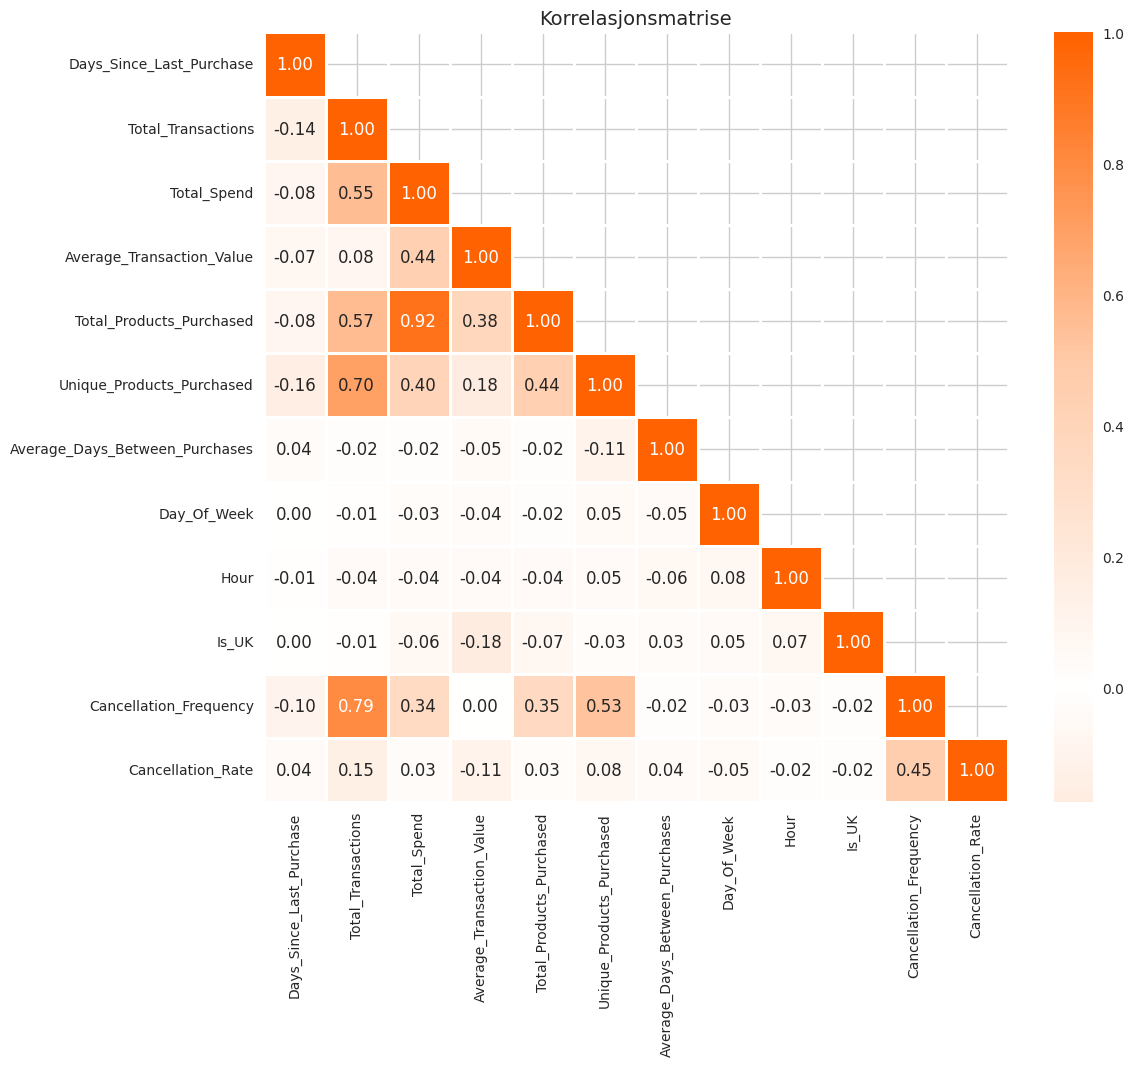

In [ ]:
# Bakgrunnsstil til plotting
sns.set_style('whitegrid')

# Beregn korrelasjonsmatrisen, ekskluder CustomerID (Er ikke feature)
corr = customer_data.drop(columns=['CustomerID']).corr()

# Fargeskala
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Lag en maske for å bare vise nedre trekant av matrisen
# (siden korrelasjonsmatrisen er symmetrisk rundt diagonalen)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plott korrelasjons-heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Korrelasjonsmatrise', fontsize=14)
plt.show()


## Steg 5 | Elbow-metoden for å finne antall clustere

Elbow-metoden er en teknikk for å velge optimalt antall clustre (K).  
- Vi kjører KMeans for ulike K-verdier (f.eks. 2 til 15).  
- For hvert K beregnes *inertia* (summen av avstander til nærmeste senter).  
- Vi plottet inertia mot K.  
 Punktet kurven begynner å "flate ut" kalles *elbow*, og representerer et godt valg for K (Antall clustre).  


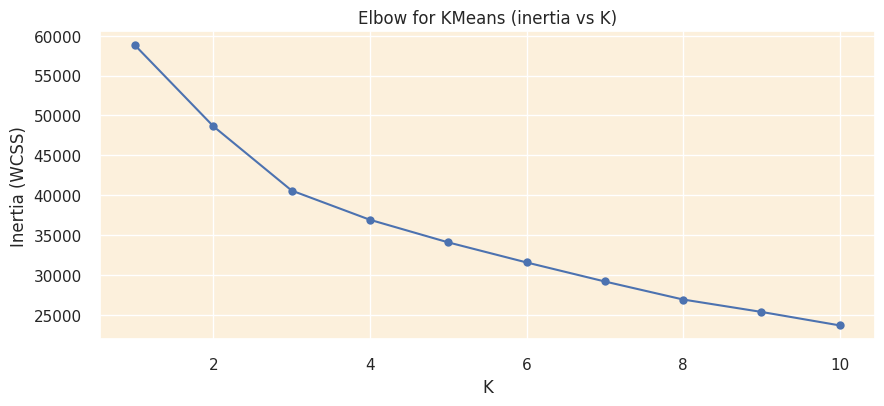

In [ ]:
# 1) Velg datasett for clustering
customer_data_cluster = customer_data_scaled.copy()

# 2) Dropper kolonner som ikke skal inn i modell
drop_cols = ['CustomerID']
X = customer_data_cluster.drop(columns=drop_cols, errors='ignore').values

# 3) Finn K med enkel Elbow (uten ekstra biblioteker)
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})
ks = range(1, 11)
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=400, random_state=0)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(10,4))
plt.plot(ks, inertias, marker='o')
plt.title('Elbow for KMeans (inertia vs K)')
plt.xlabel('K')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

In [ ]:
# 4) Velg antall clustere for baseline
K_BASE = 3
km = KMeans(n_clusters=K_BASE, init='k-means++', n_init=10, max_iter=400, random_state=0)
labels = km.fit_predict(X)

# 5) Legg klyngeetiketter i dataframen
customer_data_cluster['cluster'] = labels

# 6) Rask sjekk
sizes = pd.Series(labels).value_counts().sort_index()
sil = silhouette_score(X, labels) if X.shape[0] > K_BASE else np.nan

print(f"Klyngestørrelser: {sizes.to_dict()}")
print(f"Silhouette-score (baseline): {sil:.3f}")


Klyngestørrelser: {0: 2152, 1: 17, 2: 2193}
Silhouette-score (baseline): 0.232


In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

pca3 = PCA(n_components=3, random_state=0)
X_3d = pca3.fit_transform(X)

fig = go.Figure()
for cl in np.unique(labels):
    mask = labels == cl
    fig.add_trace(go.Scatter3d(
        x=X_3d[mask,0], y=X_3d[mask,1], z=X_3d[mask,2],
        mode='markers',
        marker=dict(size=4, opacity=0.5),
        name=f'Cluster {cl}'
    ))

fig.update_layout(
    title=dict(text=f'3D-visualisering av KMeans K={K_BASE} (PCA, kun for visning)', x=0.5),
    scene=dict(
        xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3',
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white'),
    ),
    width=900, height=650
)
fig.show()


In [ ]:
customer_data_cluster

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Total_Products_Purchased,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,cluster
0,12346.0,1.997984,-0.329598,-0.229229,-0.820095,-0.239340,-0.704913,-0.295645,1,-1.07679,1,0.114365,2.217081,2
1,12347.0,-0.097544,0.220952,0.292240,0.754094,0.287159,0.490069,-0.119074,1,0.65385,0,-0.394675,-0.602937,2
2,12348.0,-0.685575,-0.109378,-0.055337,0.098548,0.260170,-0.470602,0.661914,3,2.81715,0,-0.394675,-0.602937,0
3,12349.0,-1.284297,-0.439709,-0.052880,2.906405,-0.104395,0.126888,-0.295645,0,-1.50945,0,-0.394675,-0.602937,2
4,12350.0,1.826920,-0.439709,-0.193610,-0.067406,-0.197357,-0.529180,-0.295645,2,1.51917,0,-0.394675,-0.602937,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,1.484793,-0.439709,-0.207379,-0.358357,-0.229701,-0.599473,-0.295645,0,-1.50945,1,-0.394675,-0.602937,2
4358,18281.0,0.447721,-0.439709,-0.219451,-0.613464,-0.227773,-0.634620,-0.295645,6,-1.07679,1,-0.394675,-0.602937,0
4359,18282.0,-0.183076,-0.219488,-0.207863,-0.669591,-0.218348,-0.576042,0.572497,4,0.22119,1,0.114365,1.277075,0
4360,18283.0,-0.461054,1.211944,0.017541,-0.494184,0.050899,2.352835,-0.255437,3,0.65385,1,-0.394675,-0.602937,0


/tmp/ipython-input-929664176.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-929664176.py:8: UserWarning:

The palette list has more values (5) than needed (3), which may not be intended.



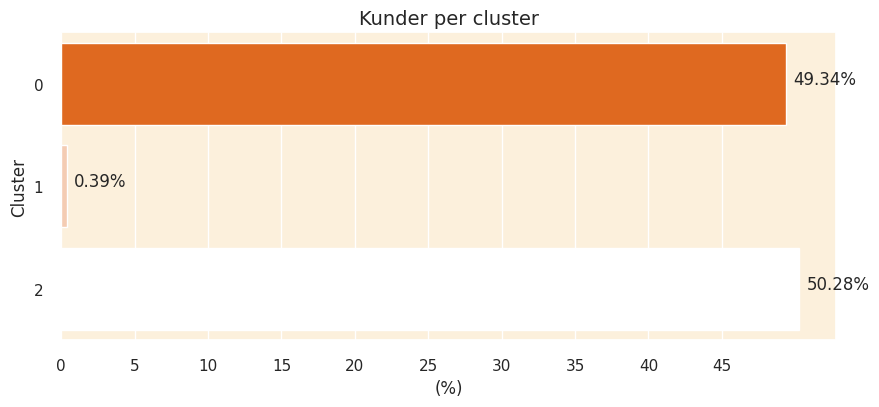

In [ ]:
# Prosent av kunder i hvert cluster
cluster_percentage = (customer_data_cluster['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Legger prosent på bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Kunder per cluster', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('(%)')


plt.show()

## Steg 10.3 | Evalueringsmetrikker

For å vurdere kvaliteten på clusteringen finnes ulike metrikker:

Her er tre eksempler på standardmetoder

- **Silhouette Score**, måler hvor godt punkter passer i egen klynge kontra nærmeste naboklynge. Høyere er bedre, område -1 til 1.  
- **Calinski–Harabasz Score**, forholdet mellom variasjon *mellom* klynger og *innenfor* klynger. Høyere er bedre.  
- **Davies–Bouldin Score**, gjennomsnittlig likhet mellom hver klynge og den mest like klyngen. Lavere er bedre.



In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Datasett med 'cluster'-kolonne
df_eval = customer_data_cluster.copy()

# Trekk ut features (dropp identifikatorer og clusterlabel)
drop_cols = [c for c in ['CustomerID', 'cluster'] if c in df_eval.columns]
X_eval = df_eval.drop(columns=drop_cols)
y_clusters = df_eval['cluster']

# Beregn metrikker
num_observations = len(df_eval)
sil_score = silhouette_score(X_eval, y_clusters, metric='euclidean')
calinski_score = calinski_harabasz_score(X_eval, y_clusters)
davies_score = davies_bouldin_score(X_eval, y_clusters)

# Vis som tabell
metrics_df = pd.DataFrame(
    {
        "Metric": [
            "Silhouette Score",
            "Calinski–Harabasz Score",
            "Davies–Bouldin Score",
        ],
        "Value": [
            round(sil_score, 6),
            round(calinski_score, 6),
            round(davies_score, 6),
        ],
    }
)
display(metrics_df)


,Metric,Value
0,Silhouette Score,0.232398
1,Calinski–Harabasz Score,976.429451
2,Davies–Bouldin Score,1.363348


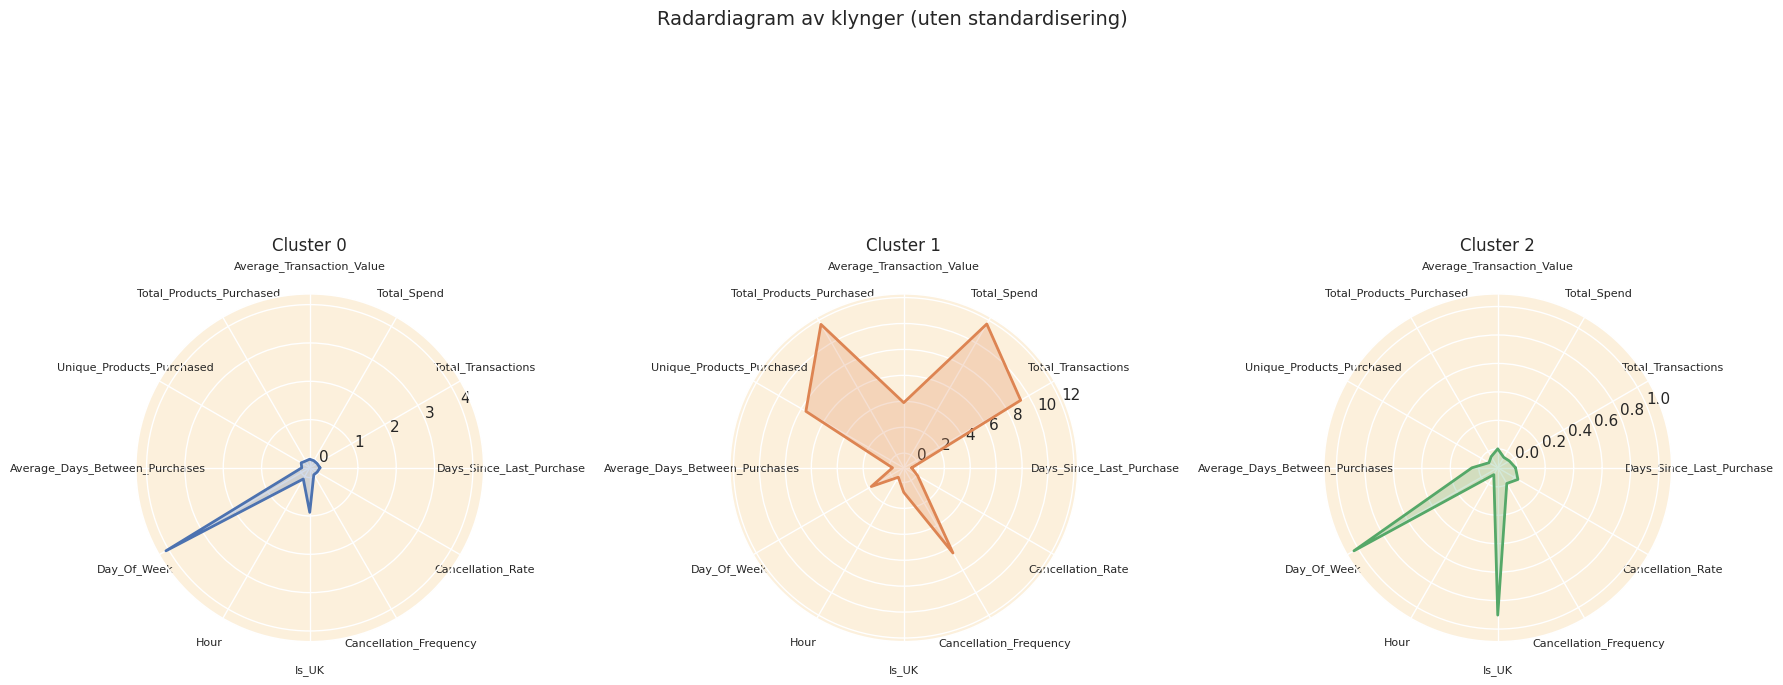

In [ ]:
# --- 1) Bruk datasettet direkte (uten StandardScaler) ---
df_viz = customer_data_cluster.copy()

drop_cols = [c for c in ['CustomerID', 'cluster'] if c in df_viz.columns]
feature_cols = [c for c in df_viz.columns if c not in drop_cols]

# Beregn gjennomsnitt (centroid) for hver klynge
centroids_raw = df_viz.groupby('cluster')[feature_cols].mean()

# --- 2) Radaroppsett ---
def radar_axes(n_vars):
    angles = np.linspace(0, 2*np.pi, n_vars, endpoint=False).tolist()
    angles += angles[:1]
    return angles

def plot_cluster_radar(ax, angles, values, color, title):
    vals = values.tolist() + values.tolist()[:1]
    ax.fill(angles, vals, alpha=0.25, color=color)
    ax.plot(angles, vals, linewidth=2, color=color)
    ax.set_title(title, y=1.10, fontsize=12)

clusters = centroids_raw.index.tolist()
n_clusters = len(clusters)
n_vars = len(feature_cols)
angles = radar_axes(n_vars)

prop_cycle = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5'])

fig, axes = plt.subplots(1, n_clusters, figsize=(min(6*n_clusters, 20), 8), subplot_kw=dict(polar=True))
if n_clusters == 1:
    axes = [axes]

for i, cl in enumerate(clusters):
    ax = axes[i]
    color = prop_cycle[i % len(prop_cycle)]
    plot_cluster_radar(ax, angles, centroids_raw.loc[cl], color, f"Cluster {cl}")
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_cols, fontsize=8, rotation=45)

plt.suptitle("Radardiagram av klynger (uten standardisering)", y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# Neste steg.
- FEATURE SCALING!
- Snitt, standardavvik og utvikling på månedlig bruk?
- Vurdere *outlier detection* og behandling
 - Sjekk ut f.eks. `Isolation Forest ` algoritmen

- PCA for dimensionality reduction
 - Fjerne redundans og støy *(noice)*
 - Forenkle visualisering
 - Forbedre compute
 - Bedre clustering

- Finne mest solgt produkter innen hvert cluster?
  - Kan vi lage en produktanbefaler basert på dette?

## Feature scaling

K-means og PCA er veldig følsomme for avtander, så vi bør standardisere kontinuerlige features for å gi lik vekt til alle kolonnene.

Is_UK og Day_Of_Week kan vi la stå, siden binær og kategorisk (kodet som heltall) og trenger derfor ikke nødvendigvis skalering i denne sammenhengen.

CustomerID er kun en identifikator, den tas også ut av modelleringen.

In [ ]:
# Initialisere StandardScaler
scaler = StandardScaler()

# 1) Kolonner som ikke skal skaleres
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# 2) Velg numeriske kolonner som skal skaleres (alle minus unntakene er numeriske)
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# 3) Lage egen scaled dataframe
customer_data_scaled = customer_data.copy()

# 4) Standardiser: mean = 0, std = 1
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Se første radene
customer_data_scaled

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Spend,Average_Transaction_Value,Total_Products_Purchased,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,1.997984,-0.329598,-0.229229,-0.820095,-0.239340,-0.704913,-0.295645,1,-1.07679,1,0.114365,2.217081
1,12347.0,-0.097544,0.220952,0.292240,0.754094,0.287159,0.490069,-0.119074,1,0.65385,0,-0.394675,-0.602937
2,12348.0,-0.685575,-0.109378,-0.055337,0.098548,0.260170,-0.470602,0.661914,3,2.81715,0,-0.394675,-0.602937
3,12349.0,-1.284297,-0.439709,-0.052880,2.906405,-0.104395,0.126888,-0.295645,0,-1.50945,0,-0.394675,-0.602937
4,12350.0,1.826920,-0.439709,-0.193610,-0.067406,-0.197357,-0.529180,-0.295645,2,1.51917,0,-0.394675,-0.602937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4357,18280.0,1.484793,-0.439709,-0.207379,-0.358357,-0.229701,-0.599473,-0.295645,0,-1.50945,1,-0.394675,-0.602937
4358,18281.0,0.447721,-0.439709,-0.219451,-0.613464,-0.227773,-0.634620,-0.295645,6,-1.07679,1,-0.394675,-0.602937
4359,18282.0,-0.183076,-0.219488,-0.207863,-0.669591,-0.218348,-0.576042,0.572497,4,0.22119,1,0.114365,1.277075
4360,18283.0,-0.461054,1.211944,0.017541,-0.494184,0.050899,2.352835,-0.255437,3,0.65385,1,-0.394675,-0.602937


## Snitt, standardavvik og utvikling på månedlig bruk?

## Outlier detection og behandling?
Sjekk ut `Isolation Forest` algoritmen

## PCA for dimensionality reduction